In [1]:
import xarray as xr
import numpy as np
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import pandas as pd

np.set_printoptions(threshold=np.inf)
dirpath = '/local/data/soccom/SOCCOM_LoResQC_LIAR_05May2021_netcdf/'
f_4180 = xr.open_dataset(dirpath + '5904180QC.nc')
f_4860 = xr.open_dataset(dirpath + '5904860QC.nc')
f_4767 = xr.open_dataset(dirpath + '5904767QC.nc')

f_4180

<xarray.Dataset>
Dimensions:              (NPARAMETER: 36, N_LEVELS: 69, N_PROF: 217)
Dimensions without coordinates: NPARAMETER, N_LEVELS, N_PROF
Data variables: (12/51)
    Cruise               |S11 ...
    Station              (N_PROF) int32 ...
    Lon                  (N_PROF) float64 ...
    Lat                  (N_PROF) float64 ...
    Lat_QF               (N_PROF) |S1 ...
    Lat_QFA              (N_PROF) float64 ...
    ...                   ...
    Type                 |S1 ...
    mon_day_yr           (N_PROF) |S10 ...
    hh_mm                (N_PROF) |S5 ...
    Parameters           (NPARAMETER) |S19 ...
    JULD                 (N_PROF) datetime64[ns] ...
    REFERENCE_DATE_TIME  object ...
Attributes:
    Comments:  \n//0\n//<Encoding>UTF-8</Encoding>\n//File updated on 05/01/2...

In [2]:
#print(f_4180.Oxygen.values*100/f_4180.OxygenSat.values)

In [3]:
def get_mld_rho(fl, interp):
    density = fl.Sigma_theta.transpose().values
    if interp: 
        density = interp_var(density, fl)
    density = np.flip(density, 0)
    #density=density.reshape(1,(dim[0]*dim[1]), order='F')
    depth = fl.Depth.transpose().values
    if interp: 
        depth = interp_var(depth, fl)
    depth = np.flip(depth, 0)
        
    #depth=depth.reshape(1,(dim[0]*dim[1]), order='F')
    rhocrit = 0.02
    density[np.isnan(depth)] = float("nan")
    depth[np.isnan(density)] = float("nan")
    d10 = np.absolute(depth-10)
    dref = np.empty((1, np.size(density, 1)))
    dref[:] = np.NaN
    mld = np.empty((1,np.size(density, 1)))
    mld[:] = np.NaN
    imld = np.empty((1,np.size(density, 1))) 
    imld[:] = np.NaN
    for ii in range(np.size(density,1)):
        idx = (d10[:, ii]==np.nanmin(d10[:,ii], axis=0)).argmax()
        dref[0,ii]=depth[idx,ii]
        if (idx.size != 0):
            drho10 = density[idx, ii]
            drho10 = np.absolute(density[:,ii] - drho10);
            drho10[0:idx] = np.NaN;
            idx = (drho10>=rhocrit).argmax()
            if (idx.size == 0):
                imld[0, ii] = np.NaN
                mld[0, ii] = np.Nan
            else:
                imld[0,ii]=idx;
                mld[0,ii]=depth[idx,ii]
        else:
            imld[0, ii] = np.NaN
            mld[0, ii] = np.Nan
    imld[mld>900]=np.NaN;
    mld[mld>900]=np.NaN;
    imld = imld.flatten()
    mld = mld.flatten()
    end = len(depth)
    depth_cat = np.stack((depth[0:end-1,:],depth[1:end,:]),axis=2);
    dpth_mid=np.nanmean(depth_cat, axis=2)
    depth2 = np.vstack((depth[0,:],dpth_mid,depth[end-1,:]))
    thickn=np.diff(depth2,axis=0);

    return mld, imld, thickn


In [4]:
def set_oxygen_var(fl):
    oxygen = fl.Oxygen.transpose().values
    oxygen_qf = fl.Oxygen_QFA.transpose().values
    oxygen_qf = oxygen_qf == 0
    oxygen[~oxygen_qf] = np.nan
    return oxygen
def set_oxygen_sat_var(fl):
    oxygen = fl.OxygenSat.transpose().values
    oxygen_qf = fl.OxygenSat_QFA.transpose().values
    oxygen_qf = oxygen_qf == 0
    oxygen[~oxygen_qf] = np.nan
    return oxygen
def set_nitrate_var(fl):
    nitrate = fl.Nitrate.transpose().values
    nitr_qf = fl.Nitrate_QFA.transpose().values
    nitr_qf = np.logical_or(nitr_qf ==0, nitr_qf == 4)
    nitrate[~nitr_qf] = np.nan
    return nitrate

# O2 Budget for One Float, One Year

<ipython-input-3-72fe2002e3d6>:46: RuntimeWarning: Mean of empty slice
  dpth_mid=np.nanmean(depth_cat, axis=2)
<ipython-input-8-c4bece4f9527>:8: RuntimeWarning: invalid value encountered in double_scalars
  avg_var[i] = np.nansum(variable[0:int(imld[i]),i]*thickn[0:int(imld[i]),i])/np.nansum(thickn[0:int(imld[i]),i])
<ipython-input-3-72fe2002e3d6>:46: RuntimeWarning: Mean of empty slice
  dpth_mid=np.nanmean(depth_cat, axis=2)
<ipython-input-3-72fe2002e3d6>:46: RuntimeWarning: Mean of empty slice
  dpth_mid=np.nanmean(depth_cat, axis=2)


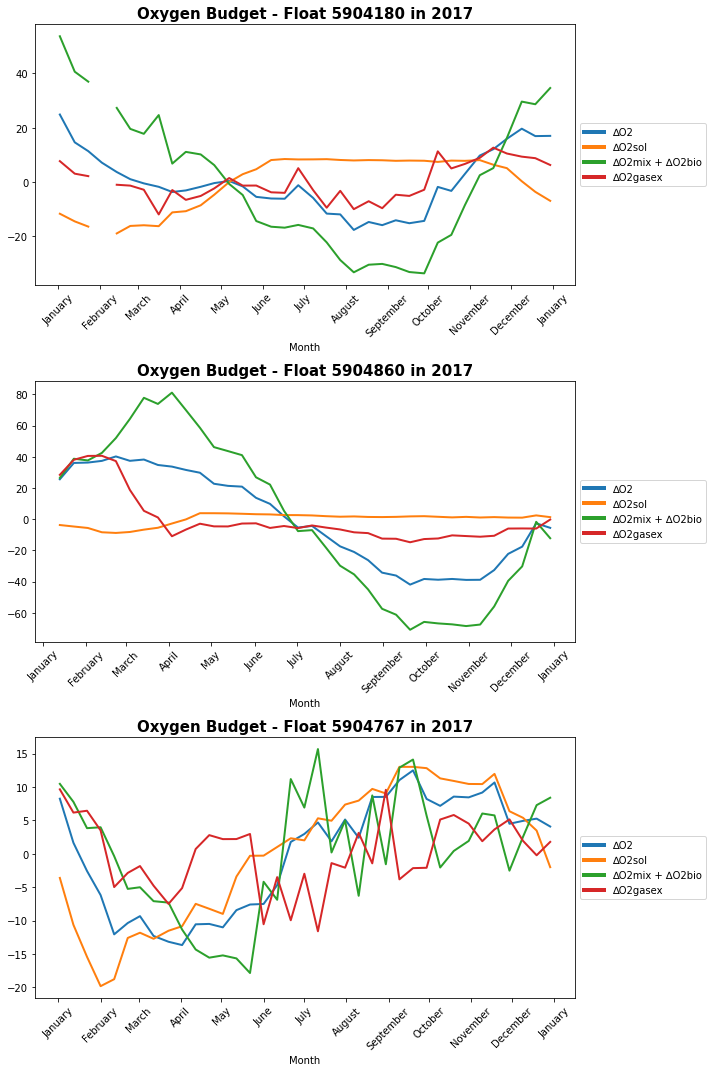

In [8]:
np.set_printoptions(suppress=True)
def find_mld_avg(var):
    variable = np.flip(var, 0)
    variable[variable==0] = np.nan
    thickn[np.isnan(variable)] = np.nan
    avg_var = np.empty((1,np.size(variable, 1))).flatten()
    for i in range(len(imld)):
        avg_var[i] = np.nansum(variable[0:int(imld[i]),i]*thickn[0:int(imld[i]),i])/np.nansum(thickn[0:int(imld[i]),i])
    return avg_var
floats = [f_4180, f_4860, f_4767]
fl_names = ['5904180', '5904860', '5904767']
fig = plt.figure(figsize=(10,15))

for fl in range(len(floats)):
    
    time = floats[fl].JULD.values
    dates = pd.to_datetime(time).year    
    dayofyear = floats[fl].JULD.dt.dayofyear        

    mld, imld, thickn = get_mld_rho(floats[fl], False)

    #temporary (just for one yr)
    mld = mld[dates==2017]
    imld = imld[dates==2017]
    thickn = thickn[:,dates==2017]

    #set up o2, o2sat, no3
    o2 = set_oxygen_var(floats[fl])
    o2 = o2[:,dates==2017]
    oxygenSat = set_oxygen_sat_var(floats[fl])
    oxygenSat = oxygenSat[:,dates==2017]

    #calculate O2sol
    o2sol = (o2/oxygenSat*100)

    #calculate AOU 
    aou = o2sol - o2

    #calculate mld averages for O2, NO3, AOU
    no3 = set_nitrate_var(floats[fl])
    no3 = no3[:,dates==2017]
    variables = [o2, no3, aou]
    o2_mld = no3_mld = aou_mld = np.empty((1,np.size(o2, 1))).flatten()


    o2_mld = find_mld_avg(o2)
    no3_mld = find_mld_avg(no3)
    aou_mld = find_mld_avg(aou)


    #calculate ∆AOU
    aou_am = np.nanmean(aou_mld, axis=0)
    d_aou = aou_mld-aou_am

    #calculate ∆O2
    o2_am = np.nanmean(o2_mld, axis=0)
    d_o2 = o2_mld-o2_am

    #calculate ∆NO3
    no3_am = np.nanmean(no3_mld, axis=0)
    d_no3 = no3_mld-no3_am

    #calculate ∆O2sol
    d_o2sol = d_o2 + d_aou

    #calculate ∆O2mix + ∆O2bio
    r = -170/16
    d_o2mixbio = d_o2 + r*d_no3

    #calculate ∆O2gasex
    d_o2gasex = np.negative(d_aou) - r*d_no3

    #create plot
    o2_vars = [d_o2, d_o2sol, d_o2mixbio, d_o2gasex]
    varNames = ['∆O2', '∆O2sol', '∆O2mix + ∆O2bio', '∆O2gasex']

    ax = fig.add_subplot(3,1, fl +1)

    for var in range(len(o2_vars)): 
        ax.plot(dayofyear.values[dates==2017], o2_vars[var], linewidth=2, label=varNames[var])
    #ax.plot(dayofyear.values[dates==2017], mld, color = 'black')

    date_form = DateFormatter("%B") # %m for month number
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    leg_lines = leg.get_lines()
    leg_texts = leg.get_texts()
    ax.set_xlabel('Month')
    plt.xticks(rotation = 45)
    plt.setp(leg_lines, linewidth=4)
    plt.title('Oxygen Budget - Float ' + fl_names[fl] + ' in 2017', fontweight='bold', fontsize='15')
    #plt.ylim([-90, 90])

    fig.tight_layout()

